In [1]:
import numpy as np

from src.environments import GridWorldEnv
from src.agents.ql import QLearning, FHQLearning
from src.agents.dp import BackwardPropagation, FrontPolicyImprovement, BackPolicyImprovement
from src.utils import Discretizer
from src.trainer import run_experiment
from src.plots import plot_gridworld

import numpy as np
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.decomposition import parafac
from src.models import PARAFAC

from itertools import product

import torch
from tensorly.tenalg import khatri_rao


In [4]:
# GridWorld

ALPHA_Q = 0.9
ALPHA_TLR = 0.001
GAMMA = 0.99
E = 50_000
H = 5
EPS = 1.0
EPS_DECAY = 0.9999
K = 8
SCALE = 0.1

ENV = GridWorldEnv()

DISCRETIZER = Discretizer(
    min_points_states=[0, 0],
    max_points_states=[4, 4],
    bucket_states=[5, 5],
    min_points_actions=[0],
    max_points_actions=[3],
    bucket_actions=[4],
)

In [5]:


fhq_learner = FHQLearning(DISCRETIZER, ALPHA_Q, H)

_ = run_experiment(0, E, H, EPS, EPS_DECAY, ENV, fhq_learner)

mat_q = np.max(fhq_learner.Q, axis=3)[0].reshape(ENV.W, ENV.W)



KeyboardInterrupt: 

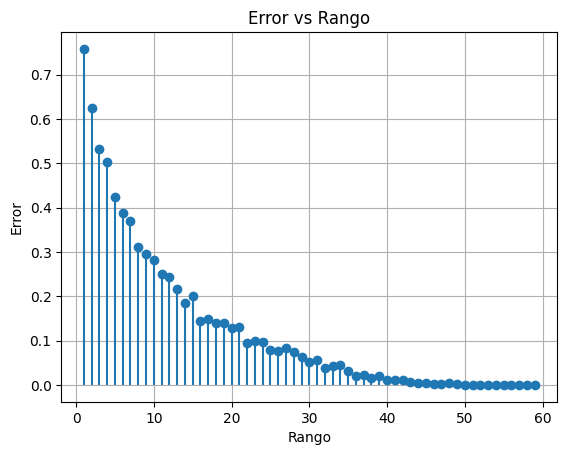

In [4]:
from src.plots import plot_gridworld, plot_errors, plot_tensor_rank

plot_tensor_rank(fhq_learner.Q, "P1")

In [3]:
# Creamos la función Q
discretizer = Discretizer(
    min_points_states=[0, 0],
    max_points_states=[4, 4],
    bucket_states=[5, 5],
    min_points_actions=[0],
    max_points_actions=[3],
    bucket_actions=[4],
)
Q = np.zeros(
            np.concatenate([[H], discretizer.bucket_states, discretizer.bucket_actions])
        )

In [9]:
nS = ENV.nS
nA = ENV.nA
W = ENV.W
R = ENV.R
P = ENV.P

bp_learner = BackwardPropagation(H,nS,nA,R,P)
fpi_learner = FrontPolicyImprovement(H,nS,nA,R,P)
bpi_learner = BackPolicyImprovement(H,nS,nA,R,P)

_ = bp_learner.run()
_, error_fpi = fpi_learner.run()
_, error_bpi = bpi_learner.run()

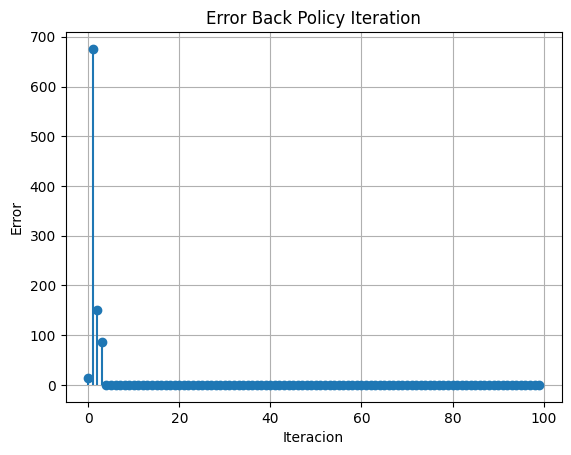

In [107]:
plt.stem(error_fpi, basefmt=" ")
plt.title("Error Back Policy Iteration")
plt.xlabel("Iteracion")
plt.ylabel("Error")
plt.grid(True)
plt.show()


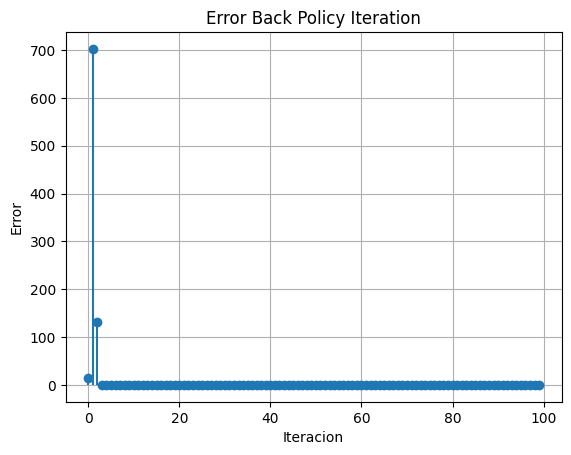

In [108]:
plt.stem(error_bpi, basefmt=" ")
plt.title("Error Back Policy Iteration")
plt.xlabel("Iteracion")
plt.ylabel("Error")
plt.grid(True)
plt.show()


BACKGUARDS INDUCTION

In [85]:
Q = np.zeros(
            np.concatenate([[H], [nS], [nA]])
        )
R_sa = np.sum(np.multiply(R, P),axis=0)
for h in range(1,H+1):
    if h == 1:
        Q[H-h,:,:] = R_sa
    else:
        Q[H-h,:,:] = R_sa + np.sum((P*np.max(Q[H-(h-1),:,:], axis=1)[:,np.newaxis,np.newaxis]),axis=0)

Q_BP = np.zeros(
            np.concatenate([[H], discretizer.bucket_states, discretizer.bucket_actions])
        )
for h in range(H):
    for a in range(nA):
        Q_BP[h,:,:,a] = np.transpose(Q[h,:,a].reshape((5,5)))

print(np.linalg.norm(fhq_learner.Q[:,:,:,:]-Q_BP))

In [102]:
Q_reshape = np.zeros(
    np.concatenate([[H], discretizer.bucket_states, discretizer.bucket_actions])
)
for h in range(H):
    for nA, a in enumerate(product(*[ np.arange(0,da) for da in discretizer.bucket_actions])):
        Q_reshape [h,...,a] = np.transpose(Q[h,:,nA].reshape(*discretizer.bucket_states))


In [103]:
print(np.linalg.norm(Q_reshape[:,:,:,:]-Q_BP[:,:,:,:]))

0.0


POLICY ITERATION

In [10]:
R_sa = np.sum(np.multiply(R, P),axis=0)
P_sa_s = np.transpose(P, (1, 2, 0))
Q = np.zeros(
            np.concatenate([[H], [nS], [nA]])
        )
def policy_evaluation1(Pi):
    V = np.zeros((H,nS))
    for _ in range(100):
        for h in range(H):
            P_s_s = np.einsum('ijk, ij -> ik', P_sa_s, Pi[h,:])
            R_s = np.einsum('ij, ij -> i', R_sa, Pi[h,:])
            V[h,:] = R_s
            if h < H-1 :
                V[h,:] += P_s_s @ V[h+1,:]
        
    Q = np.roll((R_sa[:,:,np.newaxis] +P_sa_s @ np.transpose(V)), shift=-1, axis=2)
    Q[:,:,H-1] = R_sa
    return V, np.transpose(Q,(2,0,1))

def policy_evaluation2(Pi):
    V = np.zeros((H,nS))
    R_h_sa = np.zeros((H,nS,nA))
    for h in range(1,H+1):
        P_s_s = np.einsum('ijk, ij -> ik', P_sa_s, Pi[H-h,:])
        R_s = np.einsum('ij, ij -> i', R_sa, Pi[H-h,:])
        if h == 1:
            V[H-h,:] = R_s
        else:
            V[H-h,:] = R_s + P_s_s @ V[H-(h-1),:]
    for h in range(H):
        if h == H-1:
            Q[h,:,:] = R_sa
        else:
            Q[h,:,:] = R_sa +P_sa_s @ V[h+1,:]  
    return V, Q


def policy_improvement(Q):
    Pi = np.zeros((H,nS, nA))
    for h in range(H):
        for s in range(nS):
            a = np.argmax(Q[h, s, :])
            Pi[h,s, a] = 1
    return Pi

V_old = np.zeros((H,nS))
Q_old = np.zeros((H,nS, nA))
Pi = np.random.rand(H,nS, nA)
Pi /= Pi.sum(axis=1, keepdims=True)
error_plicy = []
for _ in range(100):
    V, Q = policy_evaluation1(Pi)
    Pi = policy_improvement(Q)

    #print(V)
    #assert np.all(V >= V_old)
    #assert np.all(Q >= Q_old)
    
    error_plicy.append(np.linalg.norm(V - V_old))
    V_old = V
    Q_old = Q

V_policy = V
Q_policy = np.zeros(
            np.concatenate([[H], discretizer.bucket_states, discretizer.bucket_actions])
        )
for h in range(H):
    for a in range(nA):
        Q_policy[h,:,:,a] = np.transpose(Q[h,:,a].reshape((5,5)))

In [11]:
print(np.linalg.norm(fhq_learner.Q[:,:,:,:]-Q_policy[:,:,:,:]))

0.01019446942482654


DESCOMPOSICIÓN Y BCD

In [68]:
k = 8
discretizer = Discretizer(
    min_points_states=[0, 0],
    max_points_states=[4, 4],
    bucket_states=[25],
    min_points_actions=[0],
    max_points_actions=[3],
    bucket_actions=[4],
)
Q = PARAFAC(
    np.concatenate(
        [[ENV.H], discretizer.bucket_states, discretizer.bucket_actions]
    ),
    k=k,
    scale= 10,
    nA=len(discretizer.bucket_actions),
).double()

Pi = np.random.rand(ENV.H,ENV.nS, ENV.nA)*10

for factor in Q.factors:
    print(factor.shape)

reconstructed_tensor = tl.cp_to_tensor(([1]*k,[factor.detach().numpy() for factor in Q.factors]))
#print(reconstructed_tensor)
#factors =  parafac(fhq_learner.Q, rank=20)
#print(factors.weights)

torch.Size([5, 8])
torch.Size([25, 8])
torch.Size([4, 8])


In [69]:
from src.agents.bcd import calculate_Ds, calculate_Da, calculate_Dh

r = np.sum(np.multiply(ENV.R, ENV.P),axis=0).reshape(-1)
r_gorro = np.tile(r, (ENV.H, 1)).reshape(-1)
errors = []
for i in range(100):
    Pi = np.zeros((ENV.H,ENV.nS, ENV.nA))
    for h in range(ENV.H):
        for s in range(ENV.nS):
            a = np.argmax(Q.forward(np.array([h, s])).detach().numpy())
            Pi[h,s, a] = 1

    H = Q.factors[0].detach().numpy()
    A = Q.factors[1+len(discretizer.bucket_states):][0].detach().numpy()
    S = Q.factors[1:len(Q.factors)-len(discretizer.bucket_actions)][0].detach().numpy()

    S_i = np.matmul(np.linalg.pinv(calculate_Ds(S, A, H, ENV, Pi)), r_gorro).reshape(ENV.nS,k)
    A_i = np.matmul(np.linalg.pinv(calculate_Da(S, A_i, H, ENV, Pi)), r_gorro).reshape(k,ENV.nA).T
    H_i = np.matmul(np.linalg.pinv(calculate_Dh(S, A_i, H_i, ENV, Pi, k)), r_gorro).reshape(ENV.H,k)
    #error =  np.linalg.norm(S-S_i) + np.linalg.norm(A-A_i) + np.linalg.norm(H-H_i)
    error =  np.linalg.norm(H-H_i)
    errors.append(error)
    if error < 0.1:
        break
    
    new_values = [torch.tensor(H_i),torch.tensor(S_i),torch.tensor(A_i)]
    with torch.no_grad():  # Desactivamos el cálculo de gradientes para la actualización directa
        for param, new_value in zip(Q.factors, new_values):
            param.copy_(new_value)  # Copiar los nuevos valores al parámetro existente

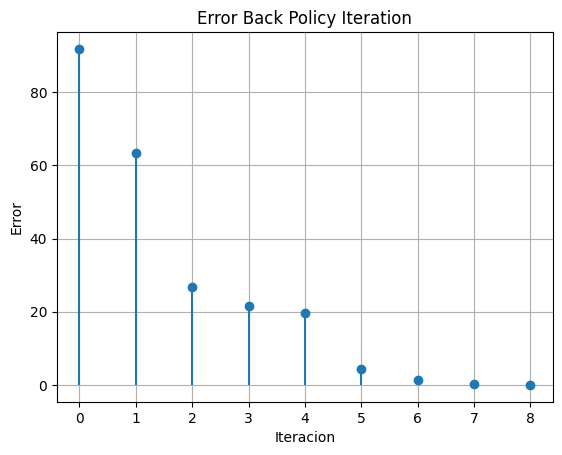

In [70]:
plt.stem(errors[:20], basefmt=" ")
plt.title("Error Back Policy Iteration")
plt.xlabel("Iteracion")
plt.ylabel("Error")
plt.grid(True)
plt.show()

In [30]:
Ds = calculate_Ds(S, A, H, ENV, Pi)
Da = calculate_Da(S, A, H, ENV, Pi)
Dh = calculate_Dh(S, A, H, ENV, Pi, k)

print(np.linalg.pinv(Ds).shape)
print(np.linalg.pinv(Da).shape)
print(np.linalg.pinv(Dh).shape)

print(np.sum(np.matmul(np.linalg.pinv(Ds), Ds)-np.eye(Ds.shape[1])))
print(np.sum(np.matmul(np.linalg.pinv(Da), Da)-np.eye(Da.shape[1])))
print(np.sum(np.matmul(np.linalg.pinv(Dh), Dh)-np.eye(Dh.shape[1])))

(200, 500)
(32, 500)
(40, 500)
-4.0273598057402124e-14
-9.544955937559798e-15
4.125163817335959e-14


In [71]:
reconstructed_tensor = tl.cp_to_tensor(([1]*k,[factor.detach().numpy() for factor in Q.factors]))
print(reconstructed_tensor[0,:])

[[ 8.25074921e+01  2.35393638e+02 -3.75589527e+02 -1.29268038e+02]
 [-7.06565381e+02 -1.83553578e+04 -9.21840368e+04 -4.29154092e+04]
 [ 2.22789491e+01  5.68461409e+02 -5.53797790e+02 -1.71289026e+02]
 [ 2.15335526e+00  8.51231767e+01 -7.73809275e+01 -2.28165544e+01]
 [ 1.57461320e+00  4.10032978e+01 -3.87287762e+01 -1.16308948e+01]
 [-1.19780784e+04 -1.60807044e+04 -6.41050861e+03 -1.22075345e+04]
 [-1.54817245e+01 -4.28626488e+02  2.56417253e+02  5.91684473e+01]
 [-1.52100619e+01  1.62094169e+02 -1.24553484e+02 -3.61664633e+01]
 [ 9.46434598e-01  3.55432443e+01 -3.63667679e+01 -1.17360056e+01]
 [-1.13472996e+01 -2.26402603e+01  4.10946832e+01  1.51798206e+01]
 [-7.88347942e+00 -3.20205506e+02  2.12332995e+02  5.22107217e+01]
 [-9.33403435e+00 -1.26490706e+02  8.08762352e+01  1.93611522e+01]
 [-7.19373253e+00  1.46935546e+02 -1.22262333e+02 -3.65369724e+01]
 [ 9.93025021e+00  7.19815938e+01 -9.56801904e+01 -3.06593579e+01]
 [ 4.01300313e+01  3.45147999e+02 -4.15933713e+02 -1.37887704e

In [37]:
k = 8
discretizer = Discretizer(
    min_points_states=[0, 0],
    max_points_states=[4, 4],
    bucket_states=[25],
    min_points_actions=[0],
    max_points_actions=[3],
    bucket_actions=[4],
)
Q = PARAFAC(
    np.concatenate(
        [[ENV.H], discretizer.bucket_states, discretizer.bucket_actions]
    ),
    k=k,
    scale= 10,
    nA=len(discretizer.bucket_actions),
).double()

Pi = np.random.rand(ENV.H,ENV.nS, ENV.nA)*10

for factor in Q.factors:
    print(factor.shape)

reconstructed_tensor = tl.cp_to_tensor(([1]*k,[factor.detach().numpy() for factor in Q.factors]))
#print(reconstructed_tensor)
#factors =  parafac(fhq_learner.Q, rank=20)
#print(factors.weights)

torch.Size([5, 8])
torch.Size([25, 8])
torch.Size([4, 8])


In [40]:
from src.agents.bcd import calculate_Ds, calculate_Da, calculate_Dh

r = np.sum(np.multiply(ENV.R, ENV.P),axis=0).reshape(-1)
r_gorro = np.tile(r, (ENV.H, 1)).reshape(-1)
gama = 10e-5
errors = []
for i in range(100) :
    Pi = np.zeros((ENV.H,ENV.nS, ENV.nA))
    for h in range(ENV.H):
        for s in range(ENV.nS):
            a = np.argmax(Q.forward(np.array([h, s])).detach().numpy())
            Pi[h,s, a] = 1
    
    H = Q.factors[0].detach().numpy()
    A = Q.factors[1+len(discretizer.bucket_states):][0].detach().numpy()
    S = Q.factors[1:len(Q.factors)-len(discretizer.bucket_actions)][0].detach().numpy()

    Ds_n = calculate_Ds(S, A, H, ENV, Pi)
    Da_n = calculate_Da(S, A, H, ENV, Pi)
    Dh_n = calculate_Dh(S, A, H, ENV, Pi, k)

    #Update S
    S_grad = np.matmul(np.transpose(Ds_n),(np.matmul(Ds_n, S.reshape(-1)) - r_gorro)).reshape(ENV.nS,k)
    S_i = (S - gama*S_grad)
    
    #Update A
    A_grad = np.matmul(np.transpose(Da_n),(np.matmul(Da_n, (A.T).reshape(-1)) + r_gorro)).reshape(k,ENV.nA).T
    A_i = (A - gama*A_grad)
    
    #Update H
    H_grad = np.matmul(np.transpose(Dh_n),(np.matmul(Dh_n, H.reshape(-1)) + r_gorro)).reshape(ENV.H,k)
    H_i = (H - gama*H_grad)
    
    #error =  np.linalg.norm(S-S_i) + np.linalg.norm(A-A_i) + np.linalg.norm(H-H_i)
    error = np.linalg.norm(S-S_i)
    print(error)
    errors.append(error)
    if error < 10^-6:
        break
    
    new_values = [torch.tensor(H),torch.tensor(S_i),torch.tensor(A)]
    with torch.no_grad():  # Desactivamos el cálculo de gradientes para la actualización directa
        for param, new_value in zip(Q.factors, new_values):
            param.copy_(new_value)  # Copiar los nuevos valores al parámetro existente

3655920206.8162208
363870202783.88
35754740292239.45
3509990599278491.5
3.478438306014483e+17
3.4688255380253413e+19
3.4667613800188934e+21
3.453783114980182e+23
3.5412768922572816e+25
3.5401538307213685e+27
3.6161461994449195e+29
3.569858223386902e+31
3.71171498861065e+33
3.737156996575447e+35
3.848373074777634e+37
3.8548487035807447e+39
4.02718982274465e+41
4.023782503277753e+43
4.232465695688228e+45
4.2344457410164015e+47
4.4267130604460486e+49
4.427179880296579e+51
4.656114687245205e+53
4.591930576074042e+55
4.907055229820075e+57
4.9377416514385785e+59
5.22016374194048e+61
5.193301659823272e+63
5.531699684587447e+65
5.550968376883355e+67
5.831214650825145e+69
5.851248263214636e+71
6.211801715383203e+73
6.196085499235453e+75
6.602442229995164e+77
6.658867026319685e+79
7.254697818173471e+81
7.337541216524343e+83
7.775144769829978e+85
7.759883037255663e+87
8.252139378575e+89
8.182654727515387e+91
8.735928392163238e+93
8.675798574498048e+95
9.324418953709197e+97
9.328556907800991e+99
9

/tmp/ipykernel_2659818/2669760334.py:27: RuntimeWarning: overflow encountered in matmul
  A_grad = np.matmul(np.transpose(Da_n),(np.matmul(Da_n, (A.T).reshape(-1)) + r_gorro)).reshape(k,ENV.nA).T
/tmp/ipykernel_2659818/2669760334.py:27: RuntimeWarning: invalid value encountered in matmul
  A_grad = np.matmul(np.transpose(Da_n),(np.matmul(Da_n, (A.T).reshape(-1)) + r_gorro)).reshape(k,ENV.nA).T
/tmp/ipykernel_2659818/2669760334.py:31: RuntimeWarning: overflow encountered in matmul
  H_grad = np.matmul(np.transpose(Dh_n),(np.matmul(Dh_n, H.reshape(-1)) + r_gorro)).reshape(ENV.H,k)
/tmp/ipykernel_2659818/2669760334.py:31: RuntimeWarning: invalid value encountered in matmul
  H_grad = np.matmul(np.transpose(Dh_n),(np.matmul(Dh_n, H.reshape(-1)) + r_gorro)).reshape(ENV.H,k)


inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf


In [19]:
np.matmul(np.transpose(Dh_n),(np.matmul(Dh_n, H.reshape(-1)) + r_gorro)).shape

(40,)

In [39]:
errors

[7112.034137377502, 470885.8217718536, 39925725.85394454]

In [12]:
print(np.matmul(Ds_n, S.reshape(-1).detach().numpy()).shape)
print(np.transpose(Ds_n).shape)

(500,)
(200, 500)


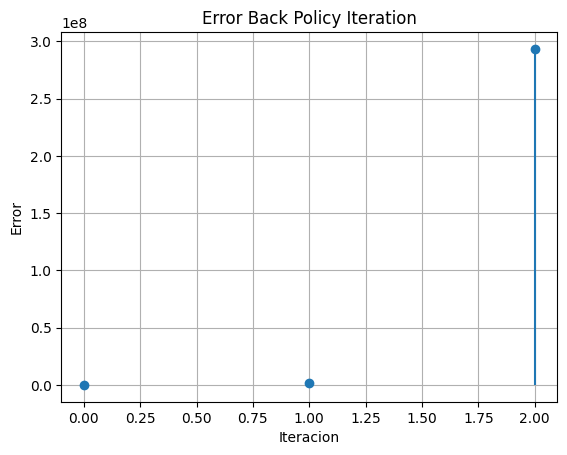

In [31]:
plt.stem(errors, basefmt=" ")
plt.title("Error Back Policy Iteration")
plt.xlabel("Iteracion")
plt.ylabel("Error")
plt.grid(True)
plt.show()

In [27]:
reconstructed_tensor = tl.cp_to_tensor(([1]*k,[factor.detach().numpy() for factor in Q.factors]))
print(reconstructed_tensor[0,:])

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [3]:
k = 8
discretizer = Discretizer(
    min_points_states=[0, 0],
    max_points_states=[4, 4],
    bucket_states=[25],
    min_points_actions=[0],
    max_points_actions=[3],
    bucket_actions=[4],
)
Q = PARAFAC(
    np.concatenate(
        [[ENV.H], discretizer.bucket_states, discretizer.bucket_actions]
    ),
    k=k,
    scale= 1000,
    nA=len(discretizer.bucket_actions),
).double()

Pi = np.random.rand(ENV.H,ENV.nS, ENV.nA)*10

for factor in Q.factors:
    print(factor.shape)

reconstructed_tensor = tl.cp_to_tensor(([1]*k,[factor.detach().numpy() for factor in Q.factors]))
#print(reconstructed_tensor)
#factors =  parafac(fhq_learner.Q, rank=20)
#print(factors.weights)

torch.Size([5, 8])
torch.Size([25, 8])
torch.Size([4, 8])


In [4]:
P_sa_sa = np.zeros((ENV.nS*ENV.nA, ENV.nS*ENV.nA))
Pi = np.random.rand(ENV.H,ENV.nS, ENV.nA)
Pi /= Pi.sum(axis=1, keepdims=True)
Pi_h = Pi[0,:]
print(Pi_h.shape)
P_sa_s = np.transpose(ENV.P, (1, 2, 0)).reshape(ENV.nS*ENV.nA,ENV.nS)

P_sa_sa = np.zeros((ENV.nS*ENV.nA, ENV.nS*ENV.nA))
for nSnA in range(ENV.nS*ENV.nA):
    P_sa_sa[nSnA,:] = (Pi_h * P_sa_s[nSnA,:].reshape(-1, 1)).reshape(-1)

print(P_sa_sa.shape)

(25, 4)
(100, 100)


In [5]:
# Norma del problema 1
norm = []
P1 = []
r = np.sum(np.multiply(ENV.R, ENV.P),axis=0).reshape(-1)
Q_h = tl.cp_to_tensor(([1]*k,[factor.detach().numpy() for factor in Q.factors]))
for h in range(ENV.H):
    if h < ENV.H-1:
        P_pi_h = np.zeros((ENV.nS*ENV.nA, ENV.nS*ENV.nA))
        Pi_h = Pi[h,:]
        for nSnA in range(ENV.nS*ENV.nA):
            P_pi_h[nSnA,:] = (Pi_h * P_sa_s[nSnA,:].reshape(-1, 1)).reshape(-1)
        norm.append(np.linalg.norm(r+np.matmul(P_pi_h,Q_h[h+1,:].reshape(-1))-Q_h[h,:].reshape(-1))**2)
        P1.append(r+np.matmul(P_pi_h,Q_h[h+1,:].reshape(-1))-Q_h[h,:].reshape(-1))
    else:
        norm.append(np.linalg.norm(r-Q_h[h,:].reshape(-1))**2)
        P1.append(r-Q_h[h,:].reshape(-1))

print(np.sum(norm))

2.464567811638547e+21


In [18]:
Da.shape

(500, 32)

In [15]:
from src.agents.bcd import calculate_Ds, calculate_Da, calculate_Dh



H = Q.factors[0].detach().numpy()
A = Q.factors[1+len(discretizer.bucket_states):][0].detach().numpy()
S = Q.factors[1:len(Q.factors)-len(discretizer.bucket_actions)][0].detach().numpy()

Ds = calculate_Ds(S, A, H, ENV, Pi)
Da = calculate_Da(S, A, H, ENV, Pi)
Dh = calculate_Dh(S, A, H, ENV, Pi, k)

print(np.linalg.norm(np.tile(r, (ENV.H, 1)).reshape(-1) + np.matmul(Ds,(S).reshape(-1)),ord=2)**2)
print(np.linalg.norm(np.tile(r, (ENV.H, 1)).reshape(-1) + np.matmul(Da,(A.T).reshape(-1)),ord=2)**2)
print(np.linalg.norm(np.tile(r, (ENV.H, 1)).reshape(-1) + np.matmul(Dh,(H).reshape(-1)),ord=2)**2)

8297650111.7414
8297650111.741397
8297650111.741397


In [26]:
print(Q_h[h,:].shape)
print(np.sum(np.multiply(ENV.R, ENV.P),axis=0).shape)
print(P_pi_h.shape)

(25, 4)
(25, 4)
(100, 100)


In [47]:
P_sa_s = np.transpose(ENV.P, (1, 2, 0)).reshape(ENV.nS*ENV.nA,ENV.nS)
H = ENV.H

H_t = Q.factors[0]
A_t = Q.factors[1+len(discretizer.bucket_states):][0]
S_t = Q.factors[1:len(Q.factors)-len(discretizer.bucket_actions)][0]


In [48]:
s = S_t.reshape(-1)
I_s = torch.eye(S_t.shape[0])
Ds_h = []
for h in range(H):
    if h == H -1:
        Y =  np.kron(I_s,khatri_rao([H_t[h].detach().numpy().reshape(1,-1), A_t.detach().numpy()]))
        Ds_h.append(-Y)
    else:
        P_pi_h = np.zeros((ENV.nS*ENV.nA, ENV.nS*ENV.nA))
        Pi_h = Pi[h,:]
        for nSnA in range(ENV.nS*ENV.nA):
            P_pi_h[nSnA,:] = (Pi_h * P_sa_s[nSnA,:].reshape(-1, 1)).reshape(-1)
        X = np.matmul(P_pi_h,np.kron(I_s,khatri_rao([H_t[h+1].detach().numpy().reshape(1,-1), A_t.detach().numpy()])))
        Y =  np.kron(I_s,khatri_rao([H_t[h].detach().numpy().reshape(1,-1), A_t.detach().numpy()]))
        Ds_h.append(X-Y)

Ds = np.vstack(Ds_h)

In [49]:
print(Ds.shape)
print(Ds_h[0].shape)
print(np.tile(r, (ENV.H, 1)).reshape(-1).shape)
print(np.matmul(Ds,(S_t).reshape(-1).detach().numpy()).shape)
print((S_t).reshape(-1).detach().numpy().shape)
print(np.matmul(Ds_h[0],(S_t).reshape(-1).detach().numpy()).shape)

(500, 200)
(100, 200)
(500,)
(500,)
(200,)
(100,)


In [30]:
np.hstack(P1)-np.hstack(a)

TypeError: dispatcher for __array_function__ did not return an iterable

In [ ]:
norm = []
a = []
for Dsh in Ds_h:
    a.append(r + np.matmul(Dsh,(S_t).reshape(-1).detach().numpy()))
    norm.append(np.linalg.norm(r + np.matmul(Dsh,(S_t).reshape(-1).detach().numpy()),ord=2)**2)
print(np.linalg.norm(np.hstack(a),ord=2)**2)
print(norm)
print(np.sum(np.array(norm)))

print(np.linalg.norm(np.tile(r, (ENV.H, 1)).reshape(-1) + np.matmul(np.vstack(Ds_h),(S_t).reshape(-1).detach().numpy()),ord=2)**2)

5.787431041321493e+21
[1.292261767534704e+21, 2.2841040182765192e+21, 8.90831653374577e+20, 8.978396495854387e+20, 4.2239395255025494e+20]
5.787431041321494e+21
5.787431041321493e+21


In [53]:
a = A_t.reshape(-1)
I_a = torch.eye(A_t.shape[0])
Da_h = []
for h in range(H):
    if h == H-1:
        Y =  np.kron(I_a,khatri_rao([H_t[h].detach().numpy().reshape(1,-1), S_t.detach().numpy()]))
        Da_h.append(-Y)
    else:
        P_pi_h = np.zeros((ENV.nS*ENV.nA, ENV.nS*ENV.nA))
        Pi_h = Pi[h,:]
        for nSnA in range(ENV.nS*ENV.nA):
            P_pi_h[nSnA,:] = (Pi_h * P_sa_s[nSnA,:].reshape(-1, 1)).reshape(-1)
        X = np.matmul(P_pi_h,np.kron(I_a,khatri_rao([H_t[h+1].detach().numpy().reshape(1,-1), S_t.detach().numpy()])))
        Y =  np.kron(I_a,khatri_rao([H_t[h].detach().numpy().reshape(1,-1), S_t.detach().numpy()]))
        Da_h.append(X-Y)

Da = np.vstack(Da_h)
            

In [54]:
print(np.linalg.norm(np.tile(r, (ENV.H, 1)).reshape(-1) + np.matmul(Da,A_t.reshape(-1).detach().numpy()))**2)

5.803916791505343e+21


In [63]:
H_t.shape

torch.Size([5, 20])

In [55]:
k = 8
h = H_t.reshape(-1)
I_h = torch.eye(A_t.shape[0])
Dh_h = []

M_h_h = []
for h in range(H):
    Mh = np.zeros((k, ENV.H*k))
    Mh[:, h*k:(h+1)*k] = np.eye(k) 
    M_h_h.append(Mh)

for h in range(H):
    if h == H-1:
        Y = np.matmul(khatri_rao([A_t.detach().numpy(), S_t.detach().numpy()]),M_h_h[h])
        Dh_h.append(-Y)
    else:
        P_pi_h = np.zeros((ENV.nS*ENV.nA, ENV.nS*ENV.nA))
        Pi_h = Pi[h,:]
        for nSnA in range(ENV.nS*ENV.nA):
            P_pi_h[nSnA,:] = (Pi_h * P_sa_s[nSnA,:].reshape(-1, 1)).reshape(-1)
        X = np.matmul(np.matmul(P_pi_h,khatri_rao([A_t.detach().numpy(), S_t.detach().numpy()])),M_h_h[h+1])
        Y = np.matmul(khatri_rao([A_t.detach().numpy(), S_t.detach().numpy()]),M_h_h[h])
        Dh_h.append(X-Y)

Dh = np.vstack(Dh_h)

In [57]:
print(np.linalg.norm(np.tile(r, (ENV.H, 1)).reshape(-1) + np.matmul(Dh,H_t.reshape(-1).detach().numpy()))**2)

5.803916791505343e+21


In [153]:
for n in range(1000):
    np.linalg.pinv(A)
    H_t = Q.factors[0]
    A_t = Q.factors[1+len(discretizer.bucket_states):][0]
    S_t = Q.factors[1:len(Q.factors)-len(discretizer.bucket_actions)][0]



SyntaxError: invalid syntax (2936027638.py, line 1)

In [42]:
len(M_h_h)

4

In [31]:
print(P_pi_h.shape)
print(khatri_rao([A_t.detach().numpy(), S_t.detach().numpy()]).shape)
print(np.matmul(P_pi_h,khatri_rao([A_t.detach().numpy(), S_t.detach().numpy()])).shape)
print(M_h_h[h+1].shape)


(100, 100)
(100, 20)
(100, 20)
(20, 100)


In [ ]:
P_sa_s = np.transpose(ENV.P, (1, 2, 0)).reshape(ENV.nS*ENV.nA,ENV.nS)
H = ENV.H

H_t = Q.factors[0]
A_t = Q.factors[1+len(discretizer.bucket_states):][0]
S_t = Q.factors[1:len(Q.factors)-len(discretizer.bucket_actions)][0]


s = S_t.reshape(-1)
I_s = torch.eye(S_t.shape[0])
Ds_h = []
for h in range(H-1):
    if h == H :
        Y =  np.kron(I_s,khatri_rao([H_t[h].detach().numpy().reshape(1,-1), A_t.detach().numpy()]))
        Ds_h.append(-Y)
    else:
        P_pi_h = np.zeros((ENV.nS*ENV.nA, ENV.nS*ENV.nA))
        Pi_h = Pi[h,:]
        for nSnA in range(ENV.nS*ENV.nA):
            P_pi_h[nSnA,:] = (Pi_h * P_sa_s[nSnA,:].reshape(-1, 1)).reshape(-1)
        X = np.matmul(P_pi_h,np.kron(I_s,khatri_rao([H_t[h+1].detach().numpy().reshape(1,-1), A_t.detach().numpy()])))
        Y =  np.kron(I_s,khatri_rao([H_t[h].detach().numpy().reshape(1,-1), A_t.detach().numpy()]))
        Ds_h.append(X-Y)

Ds = np.vstack(Ds_h)
            


In [77]:
np.kron(I_h,khatri_rao([A_t.detach().numpy(), S_t.detach().numpy()])).shape

(2000, 400)

In [52]:
Da.shape

(400, 80)

In [20]:
khatri_rao([H_t[h].detach().numpy().reshape(1,-1), A_t.detach().numpy()]).shape

(4, 20)

In [19]:
np.kron(I_s,khatri_rao([H_t[h].detach().numpy().reshape(1,-1), A_t.detach().numpy()])).shape

(20, 100)

In [17]:

print((H_t[h+1].detach().numpy().reshape(1,-1)).shape)
print((A_t.detach().numpy()).shape)
K = khatri_rao([H_t[h+1].detach().numpy().reshape(1,-1), A_t.detach().numpy()])
print(K.shape)


(1, 20)
(4, 20)
(4, 20)


In [34]:
P_sa_sa = np.zeros((ENV.nS*ENV.nA, ENV.nS*ENV.nA))
Pi = np.random.rand(ENV.H,ENV.nS, ENV.nA)
Pi /= Pi.sum(axis=1, keepdims=True)
Pi_h = Pi[0,:]
print(Pi_h.shape)
P_sa_s = np.transpose(ENV.P, (1, 2, 0)).reshape(ENV.nS*ENV.nA,ENV.nS)
for nSnA in range(ENV.nS*ENV.nA):
    print(Pi_h)
    print(P_sa_s[nSnA,:])
    print((Pi_h * P_sa_s[nSnA,:].reshape(-1, 1)).reshape(-1))

(25, 4)
[[2.42402666e-02 3.99568503e-02 2.09673365e-03 2.19900974e-02]
 [3.65233947e-02 4.65448383e-02 2.35231977e-02 8.24230834e-02]
 [3.32610454e-02 4.40178960e-02 2.39281658e-02 3.94235424e-02]
 [4.05325760e-02 5.44639777e-02 6.63593691e-02 5.01519558e-02]
 [6.14697409e-02 3.81846146e-02 5.12919273e-02 7.72066626e-02]
 [7.10874448e-02 5.51534962e-02 8.66536049e-03 4.53653939e-02]
 [2.35139667e-02 5.13513541e-02 6.65588844e-02 3.26352591e-02]
 [7.05660835e-02 5.63424680e-02 3.12371600e-02 1.61063709e-02]
 [1.50176696e-02 4.68899622e-02 3.16390321e-02 7.71694406e-03]
 [1.25115853e-03 6.36328107e-02 4.98055510e-02 6.86767504e-02]
 [6.70951807e-02 2.57326818e-02 6.44674887e-02 2.61243973e-02]
 [2.04314810e-02 3.03650913e-02 6.04656775e-02 3.60146280e-02]
 [7.31778347e-02 5.61812517e-02 5.00585374e-02 4.01177894e-02]
 [3.10917193e-03 2.44355475e-02 6.61776498e-02 6.65325203e-02]
 [1.92372664e-03 5.21908611e-02 3.91904320e-02 1.32154078e-02]
 [6.96102633e-02 1.72061704e-03 6.18677637e-02 